Stack Overflow questions

# Environment

In [ ]:
import pandas as pd
import numpy as np
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup as bs
import re
from wordcloud import WordCloud
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, hamming_loss
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
from DataGT.PCA import display_scree_plot
from sklearn.decomposition import TruncatedSVD
import gensim
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import TfidfModel
import pyLDAvis.gensim_models
from gensim.models import CoherenceModel
from imp import reload
from xgboost import XGBClassifier

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/grosjeanthibaud/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/grosjeanthibaud/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/grosjeanthibaud/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/grosjeanthibaud/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/grosjeanthibaud/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
/opt/homebrew/Caskroom/miniforge/base/envs/P5/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pan

# Data extraction

The StackExchange data explorer can be use to extract information from the SQL database:
https://data.stackexchange.com/stackoverflow/query/new \
Information about the database schema can be found at:
https://meta.stackexchange.com/questions/2677/database-schema-documentation-for-the-public-data-dump-and-sede

* We will extract the *Id*, *Title*, *Body*, and *Tags* from the *Posts* table
* We are working on questions, therefore, *TypeId* must be 1,
* We will generate 5 tags for each question, we therefore select posts with at least 5 *tags*,
* In order to select qualitative enouth posts, we select posts with a minimum *score* of 5,
* We order the extraction by *CreationDate*.

We used SQL request to obtain the .csv file from the *Exchange data explorer*:\
SELECT TOP(50000) Id, Title, Body, Tags\
From Posts\
WHERE PostTypeId = 1\
AND LEN(Tags) - LEN(REPLACE(Tags, '<','')) >= 5\
AND Score >= 5\
ORDER BY CreationDate

In [2]:
df = pd.read_csv('QueryResults.csv', index_col=0)
df.head()

,Title,Body,Tags
Id,,,
4,How to convert a Decimal to a Double in C#?,<p>I want to use a <code>Track-Bar</code> to c...,<c#><floating-point><type-conversion><double><...
11,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,<c#><datetime><time><datediff><relative-time-s...
13,Determine a user's timezone,<p>Is there a standard way for a web server to...,<html><browser><timezone><user-agent><timezone...
19,What is the fastest way to get the value of π?,<p>I'm looking for the fastest way to obtain t...,<performance><algorithm><language-agnostic><un...
25,How to use the C socket API in C++ on z/OS,<p>I'm having issues getting the C sockets API...,<c++><c><sockets><mainframe><zos>


# Data cleaning

* The database extraction contains html code, we remove it using the *BeautifulSoup* library:

* In order to keep the most relevant informationb from the cleaned text, we make the following hypothesis:
    * A question about programming is usually about how to program with something (a technology) to do something (a result), or how to optimize the code to do something,
    * Therefore, the verbs and nouns must encapsulate most of the relevant information,
    * In opposition to sentiment analysis, the adverbs are not that relevant.
* We filter the cleaned text in order to keep the verbs and nouns:

In [3]:
lemmatizer = WordNetLemmatizer()


def extract_body(text):

    # Remove the code citations, which is the text between the <code> tags
    no_code = re.sub('<code>[^>]+</code>', '', text)
    # Remove all the HTML tags
    text = bs(no_code).get_text()
    # Convert the text to lower
    text = text.lower()
    # Tokenize the text
    # tokens = word_tokenize(text, language='english')
    tokens = list(set(tokens).difference(set(stopwords.words('english')))) # we remove the stopwords
    # Remove the stop words
    tokens = [token for token in tokens if token not in stopwords.words('english')]
    # Generate the pos tags
    tags = nltk.pos_tag(tokens)
    # Select the target pos tags
    pos_filters = ['NN', 'NNP', 'NNS', 'NNPS', 'VB']
    tokens = [token for token, pos in tags if pos in pos_filters]
    # Lemmatize the result
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Format the result
    result = ','.join(tokens)

    return result

In [4]:
def extract_tags(text):

    # Remove the start and end '>' and '<'
    stripped = text.strip('<').strip('>')
    # Split the tags
    tokens = stripped.split('><')
    # tokens = [lemmatizer.lemmatize(token) for token in tokens] # We lemmatize the result
    # Format the output
    result = ','.join(tokens)

    return result

In [5]:
def extract_title(text):

    # Convert the text to lower
    text = text.lower()
    # Tokenize the text
    tokens = word_tokenize(text, language='english')
    # tokens = list(set(tokens).difference(set(stopwords.words('english')))) # we remove the stopwords
    # Remove the stop words
    tokens = [token for token in tokens if token not in stopwords.words('english')]
    # Generate the pos tags
    tags = nltk.pos_tag(tokens)
    # Select the target pos tags
    pos_filters = ['NN', 'NNP', 'NNS', 'NNPS', 'VB']
    tokens = [token.replace('?', '') for token, pos in tags if pos in pos_filters]
    # Lemmatize the result
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Format the result
    result = ','.join(tokens)

    return result

* We apply the tranformers on the datasets columns:

In [6]:
df['Body_tokens'] = df['Body'].apply(extract_body)
df['Tags_tokens'] = df['Tags'].apply(extract_tags)
df['Title_tokens'] = df['Title'].apply(extract_title)
df.head()

,Title,Body,Tags,Body_tokens,Tags_tokens,Title_tokens
Id,,,,,,
4,How to convert a Decimal to a Double in C#?,<p>I want to use a <code>Track-Bar</code> to c...,<c#><floating-point><type-conversion><double><...,"application,code,work,change,opacity,project,b...","c#,floating-point,type-conversion,double,decimal",c
11,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,<c#><datetime><time><datediff><relative-time-s...,"display,month,day,hour,value,time","c#,datetime,time,datediff,relative-time-span","c,calculate,time"
13,Determine a user's timezone,<p>Is there a standard way for a web server to...,<html><browser><timezone><user-agent><timezone...,"way,part,timezone,http,server,determine,user,p...","html,browser,timezone,user-agent,timezone-offset","determine,user,timezone"
19,What is the fastest way to get the value of π?,<p>I'm looking for the fastest way to obtain t...,<performance><algorithm><language-agnostic><un...,"challenge,constant,compare,option,version,buil...","performance,algorithm,language-agnostic,unix,pi","get,value,way"
25,How to use the C socket API in C++ on z/OS,<p>I'm having issues getting the C sockets API...,<c++><c><sockets><mainframe><zos>,"check,contains,something,define,get,fact,error...","c++,c,sockets,mainframe,zos","c++,use,c,api,z/os,socket"


# Join

In [7]:
df['Title_Body_tokens'] = df['Title_tokens'] + ',' + df['Body_tokens']
# df['Title_Body_tokens'] = df['Title_Body_tokens'].apply(lambda cell: ','.join(set(cell.split(','))))
df.head()

,Title,Body,Tags,Body_tokens,Tags_tokens,Title_tokens,Title_Body_tokens
Id,,,,,,,
4,How to convert a Decimal to a Double in C#?,<p>I want to use a <code>Track-Bar</code> to c...,<c#><floating-point><type-conversion><double><...,"application,code,work,change,opacity,project,b...","c#,floating-point,type-conversion,double,decimal",c,"c,application,code,work,change,opacity,project..."
11,Calculate relative time in C#,<p>Given a specific <code>DateTime</code> valu...,<c#><datetime><time><datediff><relative-time-s...,"display,month,day,hour,value,time","c#,datetime,time,datediff,relative-time-span","c,calculate,time","c,calculate,time,display,month,day,hour,value,..."
13,Determine a user's timezone,<p>Is there a standard way for a web server to...,<html><browser><timezone><user-agent><timezone...,"way,part,timezone,http,server,determine,user,p...","html,browser,timezone,user-agent,timezone-offset","determine,user,timezone","determine,user,timezone,way,part,timezone,http..."
19,What is the fastest way to get the value of π?,<p>I'm looking for the fastest way to obtain t...,<performance><algorithm><language-agnostic><un...,"challenge,constant,compare,option,version,buil...","performance,algorithm,language-agnostic,unix,pi","get,value,way","get,value,way,challenge,constant,compare,optio..."
25,How to use the C socket API in C++ on z/OS,<p>I'm having issues getting the C sockets API...,<c++><c><sockets><mainframe><zos>,"check,contains,something,define,get,fact,error...","c++,c,sockets,mainframe,zos","c++,use,c,api,z/os,socket","c++,use,c,api,z/os,socket,check,contains,somet..."


# Exploration

In [8]:
def gen_frequencies(series):

    dist = FreqDist(','.join(series).split(','))

    return dist


body_frequencies = gen_frequencies(df['Body_tokens'])

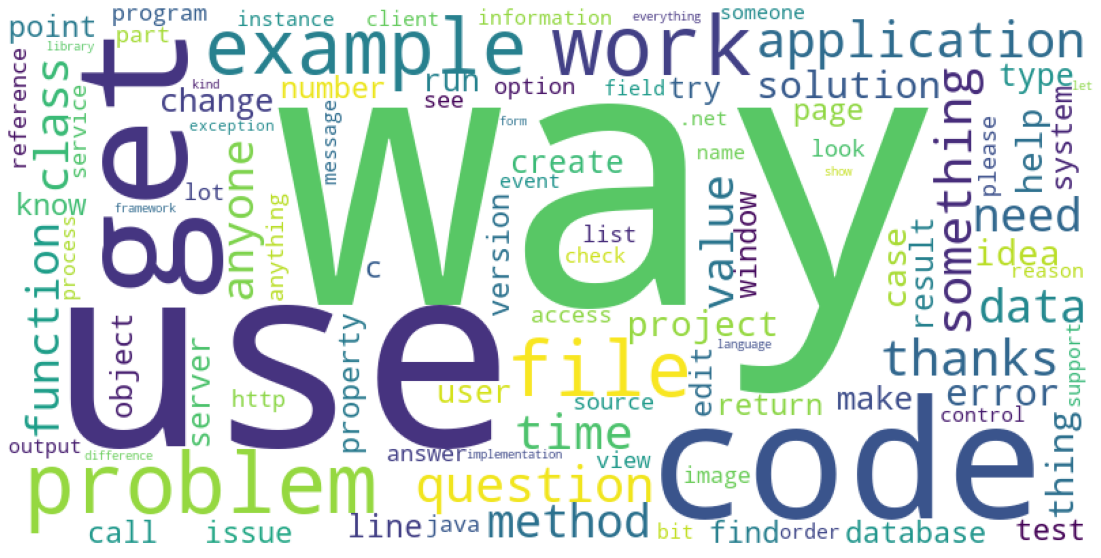

In [9]:
def word_cloud(frequencies):

    wordcloud = WordCloud(
        background_color='white',
        max_words=100,
        width=800,
        height=400
        ).generate_from_frequencies(frequencies)

    plt.figure(figsize=(20, 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()


word_cloud(body_frequencies)

In [10]:
def plot_frequencies(frequencies, name, top=10):

    uniques = len(frequencies)
    dist_df = pd.DataFrame({
        'Tag':frequencies.keys(),
        'Frequency':frequencies.values()}
        ).sort_values('Frequency').tail(top)

    fig = px.bar(
        dist_df,
        x='Frequency',
        y='Tag',
        orientation='h',
        title=f'Top {top} {name} frequencies, unique values: {uniques}',
        height=750)
    fig.show()


plot_frequencies(body_frequencies, 'Body')

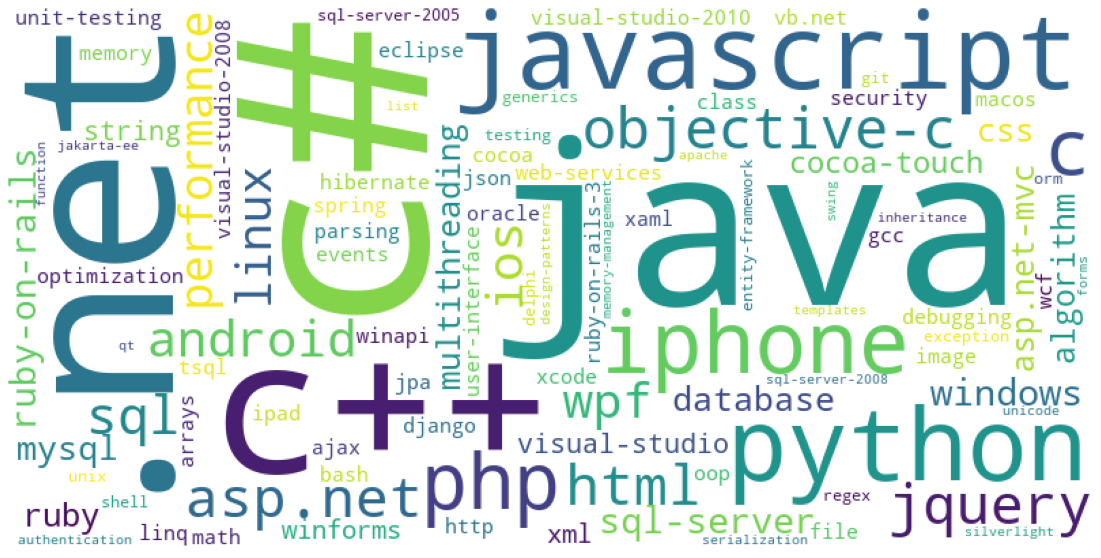

In [11]:
tags_frequencies = gen_frequencies(df['Tags_tokens'])
word_cloud(tags_frequencies)

In [12]:
plot_frequencies(tags_frequencies, 'Tags')

# LDA

* We create a dictionnary with the data and convert it to a bag of words corpus:

In [15]:
texts = df['Title_Body_tokens'].str.split(',')
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=1000)
corpus = [dictionary.doc2bow(text) for text in texts]
tfidf = TfidfModel(corpus)
corpus = [tfidf[text] for text in corpus]

* We test various N topics in order to calculate the coherence and perplexity scores:

In [16]:
topics_range = list(range(10, 200, 10))
coherence_scores = list()
perplexity_scores = list()
lda_models = list()

for n_topics in topics_range:

    lda_model = LdaMulticore(
        corpus=corpus,
        id2word=dictionary,
        num_topics=n_topics,
        random_state=42,
        passes=10,
        workers=24)
    lda_models.append(lda_model)

    perplexity_scores.append(lda_model.log_perplexity(corpus))

    coherence_model = CoherenceModel(
        model=lda_model, 
        texts=texts,
        dictionary=dictionary,
        coherence='c_v')
    coherence_scores.append(coherence_model.get_coherence())

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(x=topics_range, y=coherence_scores, name='Coherence'),
    secondary_y=False)
fig.add_trace(
    go.Scatter(x=topics_range, y=perplexity_scores, name='Perplexity'),
    secondary_y=True)
fig.update_layout(title_text=f"Scores per n topics")
fig.update_xaxes(title_text='n topics')
fig.update_yaxes(title_text="Coherence score", secondary_y=False)
fig.update_yaxes(title_text="Perplexity score", secondary_y=True)
fig.update_layout(height=600)
fig.show()

* We train the Gensim model:

Saliency: a measure of how much the term tells you about the topic.
Relevance: a weighted average of the probability of the word given the topic and the word given the topic normalized by the probability of the topic.
The size of the bubble measures the importance of the topics, relative to the data.
First, we got the most salient terms, means terms mostly tell us about what’s going on relative to the topics. We can also look at individual topic.

In [17]:
lda_model = LdaMulticore(
    corpus=corpus,
    id2word=dictionary,
    num_topics=9,
    random_state=42,
    passes=10,
    workers=24)

* We can display the results using the pyLDAvis library:

In [18]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/opt/homebrew/Caskroom/miniforge/base/envs/P5/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.

/opt/homebrew/Caskroom/miniforge/base/envs/P5/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/homebrew/Caskroom/miniforge/base/envs/P5/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/homebrew/Caskroom/miniforge/base/envs/P5/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/homebrew/Ca

When we have 5 or 10 topics, we can see certain topics are clustered together, this indicates the similarity between topics. What a a nice way to visualize what we have done thus far!

# Modelling

# Preprocessing

* Our training data is composed of both the question title and body, we apply a split to generate a traning and a test set:

In [30]:
X, y = df['Title_Body_tokens'], df['Tags_tokens']
# Apply a train test split on the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40000,), (10000,), (40000,), (10000,))

* We vectorize the corpus using a TfidVectorizer while keeping only the most frequent terms in order to limit dimensionality:

In [31]:
# X processing
MAX_FEATURES = 2500
# Keep the terms with the top frequencies
tfid_vectorizer = TfidfVectorizer(max_features=MAX_FEATURES)
# Fit and transform with the Tfid vectorizer on X train
X_train = tfid_vectorizer.fit_transform(X_train)
# Transform X test
X_test = tfid_vectorizer.transform(X_test)
X_train

<40000x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 844536 stored elements in Compressed Sparse Row format>

* Dimensionality is still high, we apply a TruncatedSVD on the train set in order to further reduce dimentionality:

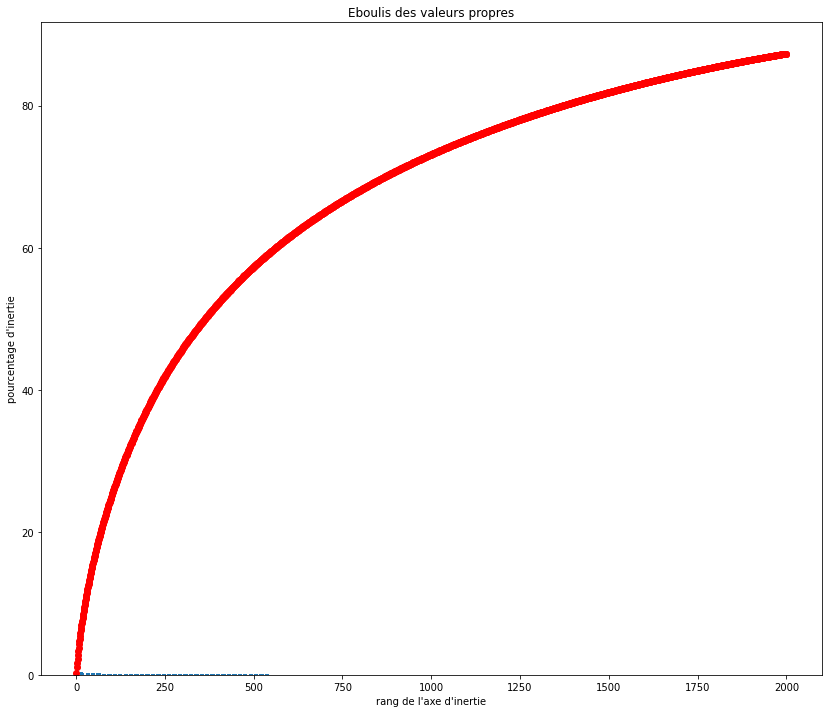

In [26]:
truncated_SVD = TruncatedSVD(n_components=MAX_FEATURES)
truncated_SVD.fit(X_train)
display_scree_plot(truncated_SVD)

* The TruncateSVD is fit around 1500 terms, when its explained variance ratio hits 80%, we transform the train set:

In [32]:
N_COMPONENTS = 1500
truncated_SVD = TruncatedSVD(n_components=N_COMPONENTS)
X_train = truncated_SVD.fit_transform(X_train)
X_train

array([[ 0.1340973 , -0.02270057, -0.03429022, ..., -0.00298935,
         0.00033127,  0.00159559],
       [ 0.17756664, -0.09049132,  0.05735124, ..., -0.02710882,
         0.01865519,  0.01361315],
       [ 0.04863797, -0.03224128,  0.01266775, ..., -0.00725977,
        -0.00539023, -0.00270196],
       ...,
       [ 0.14309099, -0.05547281, -0.05996231, ...,  0.03218982,
        -0.00307991, -0.0045025 ],
       [ 0.21820735,  0.16276956,  0.24741223, ..., -0.00541265,
         0.01529127, -0.04620658],
       [ 0.18539049, -0.04040132, -0.10516444, ..., -0.00172073,
         0.00471721, -0.00983539]])

* We create functions to detect and keep top terms:

In [14]:
def extract_top(frequencies:dict, n_top:int):

    top_values = pd.DataFrame(
        {'Tag':frequencies.keys(), 'Frequency':frequencies.values()}
        ).sort_values('Frequency', ascending=False).head(n_top)['Tag'].values
    
    return top_values

In [15]:
def keep_top(series:pd.Series, top_values:list):
    
    series = series.apply(lambda cell: list(set(cell.split(',')).intersection(top_values)))

    return series

* We detect the tags with the highest frequency on the train set and keep the corresponding tags in the test set, we then apply a MultiLabelBinarizer on the result:

In [35]:
N_TOP = 250
# y processing
# Calculate the tags frequencies
y_frequencies = gen_frequencies(y_train)
# Extract the top tags
y_top_tags = extract_top(y_frequencies, N_TOP)
# Keep only the top tags from the target
y_train = keep_top(y_train, y_top_tags)
multi_label_binarizer = MultiLabelBinarizer(classes=y_top_tags)
# Binarize the target
y_train = multi_label_binarizer.fit_transform(y_train)

y_test = keep_top(y_test, y_top_tags)
y_test = multi_label_binarizer.transform(y_test)
y_train

TypeError: sequence item 0: expected str instance, numpy.ndarray found

* The data is ready for modeling, in order to inverse the tranformations and observe the results in a human readable format, we encapsulate the transformers in a class.

# Preprocessing function

In [16]:
class DatasetTransformer():

    def __init__(self, df:pd.DataFrame, X:str, y:str):

        self.dataset = df
        self.X = X
        self.y = y
        self.X_values = df[X]
        self.y_values = df[y]
        self.y_df = None
        self.multi_label_binarizer = None
        self.tfid_vectorizer = None
        self.truncated_svd = None
    
    def gen_train_test(self, top_tags=500, max_features=750, n_components=1000):
        
        # Apply a train test split on the data
        X_train, X_test, y_train, y_test = train_test_split(
            self.X_values,
            self.y_values,
            test_size=0.2,
            random_state=42)
        
        # y processing

        # Calculate the tags frequencies
        y_frequencies = gen_frequencies(y_train)
        # Extract the top tags
        y_top_tags = extract_top(y_frequencies, top_tags)
        # Keep only the top tags from the target
        y_train = keep_top(y_train,y_top_tags)
        y_test = keep_top(y_test,y_top_tags)

        # Drop the empty rows we might have generated
        train_drop = y_train[y_train.map(len)==0].keys()
        test_drop = y_test[y_test.map(len)==0].keys()
        y_train.drop(train_drop,inplace=True)
        y_test.drop(test_drop,inplace=True)

        print(f'Dropped Train samples: {train_drop.shape[0]}')
        print(f'Dropped Test samples: {test_drop.shape[0]}')

        # Binarize the target
        self.multi_label_binarizer = MultiLabelBinarizer(classes=y_top_tags)
        y_train_matrix = self.multi_label_binarizer.fit_transform(y_train)
        y_test_matrix = self.multi_label_binarizer.transform(y_test)
        
        # Convert the matrixes back to pandas DataFrames
        tags = self.multi_label_binarizer.classes_
        y_train = pd.DataFrame(
            data=y_train_matrix,
            index=y_train.index,
            columns=tags)
        y_test = pd.DataFrame(
            data=y_test_matrix,
            index=y_test.index,
            columns=tags)

        # Extract the y data to join predictions later
        self.y_df = self.dataset.loc[y_test.index, :]

        # X processing

        X_train.drop(train_drop, inplace=True)
        X_test.drop(test_drop, inplace=True)
        # Keep the terms with the top frequencies using the max_features arg
        self.tfid_vectorizer = TfidfVectorizer(max_features=max_features)
        # Fit and transform with the Tfid vectorizer on X train
        X_train_matrix = self.tfid_vectorizer.fit_transform(X_train)
        # Transform X test
        X_test_matrix = self.tfid_vectorizer.transform(X_test)
        # Apply TruncatedSVD to reduce dimentionality
        self.truncated_svd = TruncatedSVD(n_components=n_components)
        X_train_matrix = self.truncated_svd.fit_transform(X_train_matrix)
        # Transform X test
        X_test_matrix = self.truncated_svd.transform(X_test_matrix)

        explained_variance = round(sum(
            self.truncated_svd.explained_variance_ratio_), 2)
        print(f'TruncatedSVD explained variance ratio: {explained_variance}')

        # Convert the matrixes back to pandas DataFrames
        components = list(range(n_components))
        X_train = pd.DataFrame(
            data=X_train_matrix,
            index=X_train.index,
            columns=components)
        X_test = pd.DataFrame(
            data=X_test_matrix,
            index=X_test.index,
            columns=components)

        print(f'Train size: {X_train.shape[0]}')
        print(f'Test size: {X_test.shape[0]}')

        return X_train, X_test, y_train, y_test

    def join_predictions(self, name:str, predictions:np.array, select_preds=False):

        # Use the binarizer to inverse transform the prediction array
        predictions = self.multi_label_binarizer.inverse_transform(predictions)
        # Add the predictions to the dataset
        self.y_df[name] = predictions

        return self.y_df
    
    def get_predictions(self):

        return self.y_df


transformer = DatasetTransformer(df, 'Title_Body_tokens', 'Tags_tokens')
X_train, X_test, y_train, y_test = transformer.gen_train_test()

Dropped Train samples: 752
Dropped Test samples: 195
TruncatedSVD explained variance ratio: 0.85
Train size: 39248
Test size: 9805


In [61]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
Id,,,,,,,,,,,,,,,,,,,,,
5427681,0.135483,-0.033404,0.041258,0.201388,-0.042334,-0.006261,-0.105917,0.199212,-0.037302,0.051277,...,-0.025133,0.062463,-0.014127,0.013478,0.010683,0.039672,-0.082954,0.040709,0.009284,0.008138
4291253,0.172155,0.107538,0.071467,0.017537,-0.060147,0.002551,0.018854,-0.034612,0.027285,0.019507,...,0.013961,-0.024415,0.002914,0.026786,0.025506,-0.009669,-0.020267,0.005653,0.012054,0.007537
6286656,0.048878,0.038600,0.006468,-0.011085,0.001763,0.033498,0.001968,0.002402,-0.062980,-0.023682,...,0.013178,0.010184,-0.020563,0.025629,-0.037886,-0.081529,-0.021831,-0.005312,0.002314,0.023359
2276370,0.099734,0.040549,0.086524,-0.024639,0.041430,-0.086442,0.182375,0.145439,0.037451,-0.067555,...,-0.015921,0.012765,-0.016588,-0.020572,-0.027488,0.010646,-0.009030,-0.071115,0.001669,0.040285
1911856,0.164962,0.060311,-0.058642,0.033715,0.190329,0.076368,-0.057285,-0.137613,0.003869,0.051412,...,-0.012201,-0.005835,-0.010326,0.008048,0.015295,-0.017080,-0.059366,0.016716,-0.014837,0.037440


In [62]:
y_train.head()

,c#,java,.net,c++,javascript,python,iphone,php,c,objective-c,...,multidimensional-array,xmlhttprequest,find,extension-methods,numbers,double,queue,bit-manipulation,standards,controller
Id,,,,,,,,,,,,,,,,,,,,,
5427681,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4291253,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6286656,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2276370,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1911856,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


*to remove*

In [63]:
# X_train.to_csv('./X_train.csv')
# X_test.to_csv('./X_test.csv')
# y_train.to_csv('./y_train.csv')
# y_test.to_csv('./y_test.csv')

# Evaluation function

* For each experiment, we will calculate the following metrics:
    * ...
* We create a class to evaluate and keep track of our experiments results:

In [17]:
class PerformanceReport():

    def __init__(self):

        # Initialize our report DataFrame
        self.report = pd.DataFrame(columns=[
            'Accuracy',
            'Precision_macro',
            'Precision_micro',
            'Recall_macro',
            'Recall_micro',
            'F1_macro',
            'F1_micro'])

    def evaluate(self, name:str ,y_true:np.array ,y_pred:np.array):
        
        # Calculate the scores
        accuracy = accuracy_score(y_true, y_pred)
        precision_macro = precision_score(y_true, y_pred, average='macro')
        precision_micro = precision_score(y_true, y_pred, average='micro')
        recall_macro = recall_score(y_true, y_pred, average='macro')
        recall_micro = recall_score(y_true, y_pred, average='micro')
        f1_macro = f1_score(y_true, y_pred, average='macro')
        f1_micro = f1_score(y_true, y_pred, average='micro')

        # Append the scores to our report
        self.report.loc[name,:] = [
            accuracy,
            precision_macro,
            precision_micro,
            recall_macro,
            recall_micro,
            f1_macro,
            f1_micro]
            
        print(pd.DataFrame(self.report.loc[name,:]))
    
    def get(self):

        return self.report


report = PerformanceReport()

# SVM

In [18]:
model = OneVsRestClassifier(LinearSVC())
model.fit(X_train, y_train)
preds = model.predict(X_test)
report.evaluate('SVM', y_test, preds)

/opt/homebrew/Caskroom/miniforge/base/envs/P5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



                      SVM
Accuracy          0.06823
Precision_macro  0.492602
Precision_micro  0.742057
Recall_macro      0.19083
Recall_micro     0.283153
F1_macro         0.255147
F1_micro         0.409898


In [19]:
transformer.join_predictions('SVM', preds).head()

,Title,Body,Tags,Body_tokens,Tags_tokens,Title_tokens,Title_Body_tokens,SVM
Id,,,,,,,,
4672549,C#: Any way to get around the 260 character li...,<blockquote>\n <p><strong>Possible Duplicate:...,<c#><limit><filepath><maxlength><max-path>,"people,way,hell,wonder,limit,figure,lot,ran,is...","c#,limit,filepath,maxlength,max-path","way,c,get,limit","way,c,get,limit,people,way,hell,wonder,limit,f...",()
1268009,Reset RTF in RichTextBox?,"<p>I'm trying to ""reset"" the formatting in my ...",<c#><winforms><richtextbox><rtf><richtext>,"retains,way,lot,font,color,addition,sort,clear...","c#,winforms,richtextbox,rtf,richtext","reset,rtf,richtextbox","reset,rtf,richtextbox,retains,way,lot,font,col...","(c#,)"
23770,Effective strategy for leaving an audit trail/...,<p>What are some strategies that people have h...,<database><postgresql><database-design><crud><...,"record,people,success,instance,user,strategy,o...","database,postgresql,database-design,crud,audit...","audit,trail/change,history,application,strategy","audit,trail/change,history,application,strateg...","(database,)"
1712541,Eclipse rename not working completely,<p>Ok I'm completely googled-out.</p>\n\n<p>I ...,<java><eclipse><refactoring><eclipse-3.4><ecli...,"error,source,linux,folder,workspace,convert,us...","java,eclipse,refactoring,eclipse-3.4,eclipse-3.5",eclipse,"eclipse,error,source,linux,folder,workspace,co...","(java, eclipse)"
5492485,strcmp or string::compare?,<p>I want to compare two strings. Is it possib...,<c++><c><string><char><string-comparison>,"difference,string,question,comment,knowledge,w...","c++,c,string,char,string-comparison","strcmp,:compare","strcmp,:compare,difference,string,question,com...",()


# SGD

In [20]:
model = OneVsRestClassifier(SGDClassifier(), n_jobs=-1)
model.fit(X_train, y_train)
preds = model.predict(X_test)
report.evaluate('SGD', y_test,preds)

/opt/homebrew/Caskroom/miniforge/base/envs/P5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



                      SGD
Accuracy          0.05487
Precision_macro  0.239335
Precision_micro  0.802805
Recall_macro     0.096611
Recall_micro     0.211561
F1_macro         0.125555
F1_micro         0.334874


In [21]:
transformer.join_predictions('SGD', preds).head()

,Title,Body,Tags,Body_tokens,Tags_tokens,Title_tokens,Title_Body_tokens,SVM,SGD
Id,,,,,,,,,
4672549,C#: Any way to get around the 260 character li...,<blockquote>\n <p><strong>Possible Duplicate:...,<c#><limit><filepath><maxlength><max-path>,"people,way,hell,wonder,limit,figure,lot,ran,is...","c#,limit,filepath,maxlength,max-path","way,c,get,limit","way,c,get,limit,people,way,hell,wonder,limit,f...",(),()
1268009,Reset RTF in RichTextBox?,"<p>I'm trying to ""reset"" the formatting in my ...",<c#><winforms><richtextbox><rtf><richtext>,"retains,way,lot,font,color,addition,sort,clear...","c#,winforms,richtextbox,rtf,richtext","reset,rtf,richtextbox","reset,rtf,richtextbox,retains,way,lot,font,col...","(c#,)","(c#,)"
23770,Effective strategy for leaving an audit trail/...,<p>What are some strategies that people have h...,<database><postgresql><database-design><crud><...,"record,people,success,instance,user,strategy,o...","database,postgresql,database-design,crud,audit...","audit,trail/change,history,application,strategy","audit,trail/change,history,application,strateg...","(database,)",()
1712541,Eclipse rename not working completely,<p>Ok I'm completely googled-out.</p>\n\n<p>I ...,<java><eclipse><refactoring><eclipse-3.4><ecli...,"error,source,linux,folder,workspace,convert,us...","java,eclipse,refactoring,eclipse-3.4,eclipse-3.5",eclipse,"eclipse,error,source,linux,folder,workspace,co...","(java, eclipse)","(java, eclipse)"
5492485,strcmp or string::compare?,<p>I want to compare two strings. Is it possib...,<c++><c><string><char><string-comparison>,"difference,string,question,comment,knowledge,w...","c++,c,string,char,string-comparison","strcmp,:compare","strcmp,:compare,difference,string,question,com...",(),()


# KNN

In [22]:
model = KNeighborsClassifier()
model.fit(X_train.values, y_train.values)
preds = model.predict(X_test.values)
report.evaluate('KNN', y_test.values,preds)

/opt/homebrew/Caskroom/miniforge/base/envs/P5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



                      KNN
Accuracy         0.017746
Precision_macro  0.449928
Precision_micro  0.554255
Recall_macro     0.078229
Recall_micro     0.103267
F1_macro         0.123234
F1_micro         0.174097


In [23]:
transformer.join_predictions('KNN', preds).head()

,Title,Body,Tags,Body_tokens,Tags_tokens,Title_tokens,Title_Body_tokens,SVM,SGD,KNN
Id,,,,,,,,,,
4672549,C#: Any way to get around the 260 character li...,<blockquote>\n <p><strong>Possible Duplicate:...,<c#><limit><filepath><maxlength><max-path>,"people,way,hell,wonder,limit,figure,lot,ran,is...","c#,limit,filepath,maxlength,max-path","way,c,get,limit","way,c,get,limit,people,way,hell,wonder,limit,f...",(),(),()
1268009,Reset RTF in RichTextBox?,"<p>I'm trying to ""reset"" the formatting in my ...",<c#><winforms><richtextbox><rtf><richtext>,"retains,way,lot,font,color,addition,sort,clear...","c#,winforms,richtextbox,rtf,richtext","reset,rtf,richtextbox","reset,rtf,richtextbox,retains,way,lot,font,col...","(c#,)","(c#,)",()
23770,Effective strategy for leaving an audit trail/...,<p>What are some strategies that people have h...,<database><postgresql><database-design><crud><...,"record,people,success,instance,user,strategy,o...","database,postgresql,database-design,crud,audit...","audit,trail/change,history,application,strategy","audit,trail/change,history,application,strateg...","(database,)",(),()
1712541,Eclipse rename not working completely,<p>Ok I'm completely googled-out.</p>\n\n<p>I ...,<java><eclipse><refactoring><eclipse-3.4><ecli...,"error,source,linux,folder,workspace,convert,us...","java,eclipse,refactoring,eclipse-3.4,eclipse-3.5",eclipse,"eclipse,error,source,linux,folder,workspace,co...","(java, eclipse)","(java, eclipse)",()
5492485,strcmp or string::compare?,<p>I want to compare two strings. Is it possib...,<c++><c><string><char><string-comparison>,"difference,string,question,comment,knowledge,w...","c++,c,string,char,string-comparison","strcmp,:compare","strcmp,:compare,difference,string,question,com...",(),(),()


* We obtain interesting results, a few rows have actually been predicted by the model, this is because the model outputs low porbabilities for most of its predictions.
* In order to obtain 5 tags, we are going to use the *predict_proba* method to output predictions with lower probability, using the following function:

In [24]:
def get_firsts(preds_proba, n_first):

    result = np.array([
        np.where(pred >= np.partition(pred, -n_first)[-n_first], 1, 0) 
        for pred in np.array([pred[:,1] for pred in preds_proba
        ]).transpose()])

    return result

In [25]:
preds_proba = model.predict_proba(X_test.values)
preds_firsts = get_firsts(preds_proba, 5)
report.evaluate('KNN_5', y_test.values, preds_firsts)

                    KNN_5
Accuracy         0.000204
Precision_macro  0.087104
Precision_micro  0.083809
Recall_macro     0.299077
Recall_micro      0.41573
F1_macro         0.128712
F1_micro         0.139496


In [26]:
transformer.join_predictions('KNN_5', preds_firsts).head()

,Title,Body,Tags,Body_tokens,Tags_tokens,Title_tokens,Title_Body_tokens,SVM,SGD,KNN,KNN_5
Id,,,,,,,,,,,
4672549,C#: Any way to get around the 260 character li...,<blockquote>\n <p><strong>Possible Duplicate:...,<c#><limit><filepath><maxlength><max-path>,"people,way,hell,wonder,limit,figure,lot,ran,is...","c#,limit,filepath,maxlength,max-path","way,c,get,limit","way,c,get,limit,people,way,hell,wonder,limit,f...",(),(),(),"(c#, java, .net, iphone, c, objective-c, css, ..."
1268009,Reset RTF in RichTextBox?,"<p>I'm trying to ""reset"" the formatting in my ...",<c#><winforms><richtextbox><rtf><richtext>,"retains,way,lot,font,color,addition,sort,clear...","c#,winforms,richtextbox,rtf,richtext","reset,rtf,richtextbox","reset,rtf,richtextbox,retains,way,lot,font,col...","(c#,)","(c#,)",(),"(c#, java, .net, c++, sql-server, multithreadi..."
23770,Effective strategy for leaving an audit trail/...,<p>What are some strategies that people have h...,<database><postgresql><database-design><crud><...,"record,people,success,instance,user,strategy,o...","database,postgresql,database-design,crud,audit...","audit,trail/change,history,application,strategy","audit,trail/change,history,application,strateg...","(database,)",(),(),"(c#, java, .net, c++, c, multithreading, swing..."
1712541,Eclipse rename not working completely,<p>Ok I'm completely googled-out.</p>\n\n<p>I ...,<java><eclipse><refactoring><eclipse-3.4><ecli...,"error,source,linux,folder,workspace,convert,us...","java,eclipse,refactoring,eclipse-3.4,eclipse-3.5",eclipse,"eclipse,error,source,linux,folder,workspace,co...","(java, eclipse)","(java, eclipse)",(),"(c#, java, wpf, unit-testing, eclipse, xaml, t..."
5492485,strcmp or string::compare?,<p>I want to compare two strings. Is it possib...,<c++><c><string><char><string-comparison>,"difference,string,question,comment,knowledge,w...","c++,c,string,char,string-comparison","strcmp,:compare","strcmp,:compare,difference,string,question,com...",(),(),(),"(java, c++, javascript, iphone, c, objective-c..."


In [27]:
# def set_threshold(preds_proba, threshold):

#     result = np.where(
#         np.array(
#             [pred[:,1] for pred in preds_proba]
#             ).transpose() >= threshold, 1, 0)

#     return result

In [30]:
def filter_preds(document, preds):
    
    filtered_preds = list()

    for pred in preds:

        if pred in document:

            filtered_preds.append(pred)
            preds.remove(pred)

    filtered_preds = filtered_preds[:5]

    for pred in preds:

        if len(filtered_preds) == 5:
            
            break
        
        else:

            filtered_preds.append(pred)
    
    return filtered_preds

In [31]:
def select_preds(name, transformer: DatasetTransformer, preds_proba):

    preds_df = pd.DataFrame(np.array([pred[:,1] for pred in preds_proba]).transpose(),columns=transformer.multi_label_binarizer.classes_)
    preds_lists = preds_df.apply(lambda x: x[x > 0].sort_values(ascending=False).keys().to_list(), axis=1)
    preds_array = transformer.multi_label_binarizer.transform(preds_lists.values)
    transformer.y_df[name] = preds_lists.values
    transformer.y_df[name] = transformer.y_df.apply(lambda x: filter_preds(x[transformer.y], x[name]), axis=1)

    return preds_array, transformer.y_df

In [32]:
preds_array, preds_df = select_preds('KNN_select', transformer, preds_proba)
report.evaluate('KNN_select', y_test.values, preds_array)

                KNN_select
Accuracy          0.000306
Precision_macro   0.139439
Precision_micro   0.095908
Recall_macro      0.299333
Recall_micro      0.416839
F1_macro          0.176884
F1_micro          0.155937


In [33]:
preds_df.head()

,Title,Body,Tags,Body_tokens,Tags_tokens,Title_tokens,Title_Body_tokens,SVM,SGD,KNN,KNN_5,KNN_select
Id,,,,,,,,,,,,
4672549,C#: Any way to get around the 260 character li...,<blockquote>\n <p><strong>Possible Duplicate:...,<c#><limit><filepath><maxlength><max-path>,"people,way,hell,wonder,limit,figure,lot,ran,is...","c#,limit,filepath,maxlength,max-path","way,c,get,limit","way,c,get,limit,people,way,hell,wonder,limit,f...",(),(),(),"(c#, java, .net, iphone, c, objective-c, css, ...","[c#, c, iphone, objective-c, java]"
1268009,Reset RTF in RichTextBox?,"<p>I'm trying to ""reset"" the formatting in my ...",<c#><winforms><richtextbox><rtf><richtext>,"retains,way,lot,font,color,addition,sort,clear...","c#,winforms,richtextbox,rtf,richtext","reset,rtf,richtextbox","reset,rtf,richtextbox,retains,way,lot,font,col...","(c#,)","(c#,)",(),"(c#, java, .net, c++, sql-server, multithreadi...","[c#, java, .net, c++, sql-server]"
23770,Effective strategy for leaving an audit trail/...,<p>What are some strategies that people have h...,<database><postgresql><database-design><crud><...,"record,people,success,instance,user,strategy,o...","database,postgresql,database-design,crud,audit...","audit,trail/change,history,application,strategy","audit,trail/change,history,application,strateg...","(database,)",(),(),"(c#, java, .net, c++, c, multithreading, swing...","[c, java, .net, c#, c++]"
1712541,Eclipse rename not working completely,<p>Ok I'm completely googled-out.</p>\n\n<p>I ...,<java><eclipse><refactoring><eclipse-3.4><ecli...,"error,source,linux,folder,workspace,convert,us...","java,eclipse,refactoring,eclipse-3.4,eclipse-3.5",eclipse,"eclipse,error,source,linux,folder,workspace,co...","(java, eclipse)","(java, eclipse)",(),"(c#, java, wpf, unit-testing, eclipse, xaml, t...","[java, eclipse, c#, wpf, unit-testing]"
5492485,strcmp or string::compare?,<p>I want to compare two strings. Is it possib...,<c++><c><string><char><string-comparison>,"difference,string,question,comment,knowledge,w...","c++,c,string,char,string-comparison","strcmp,:compare","strcmp,:compare,difference,string,question,com...",(),(),(),"(java, c++, javascript, iphone, c, objective-c...","[c, c++, iphone, java, javascript]"


# Random Forest

In [35]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)
preds_proba = model.predict_proba(X_test)
report.evaluate('Random_Forest', y_test,preds)

KeyboardInterrupt: 

In [ ]:
report.evaluate('Random_Forest', y_test,preds)

/opt/homebrew/Caskroom/miniforge/base/envs/P5/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Accuracy           0.029237
Precision_macro    0.212511
Precision_micro    0.810272
Recall_macro       0.044826
Recall_micro       0.178239
F1_macro           0.065837
F1_micro           0.292201
Name: Random Forest, dtype: object


In [ ]:
transformer.join_predictions('Random_Forest', preds_threshold)

,Title,Body,Tags,Body_tokens,Tags_tokens,Title_tokens,Title_Body_tokens,KNN,SVM,SGD,RandomForest
Id,,,,,,,,,,,
4672549,C#: Any way to get around the 260 character li...,<blockquote>\n <p><strong>Possible Duplicate:...,<c#><limit><filepath><maxlength><max-path>,"duplicate,character,path,length,limit,exist,wi...","c#,limit,filepath,maxlength,max-path","way,character,limit,path","way,character,limit,path,duplicate,character,p...",(),(),(),"(c#, windows)"
1268009,Reset RTF in RichTextBox?,"<p>I'm trying to ""reset"" the formatting in my ...",<c#><winforms><richtextbox><rtf><richtext>,"reset,richtextbox,winforms,wpf,matter,complain...","c#,winforms,richtextbox,rtf,richtext","reset,rtf,richtextbox","reset,rtf,richtextbox,reset,richtextbox,winfor...",(),"(c#, wpf)","(c#,)","(c#, .net, wpf, winforms)"
23770,Effective strategy for leaving an audit trail/...,<p>What are some strategies that people have h...,<database><postgresql><database-design><crud><...,"strategy,people,success,history,data,database,...","database,postgresql,database-design,crud,audit...","strategy,audit,trail/change,history,db,applica...","strategy,audit,trail/change,history,db,applica...",(),"(database,)",(),"(sql, database, postgresql)"
1712541,Eclipse rename not working completely,<p>Ok I'm completely googled-out.</p>\n\n<p>I ...,<java><eclipse><refactoring><eclipse-3.4><ecli...,"googled-out,project,workspace,project,source,f...","java,eclipse,refactoring,eclipse-3.4,eclipse-3.5","eclipse,rename","eclipse,rename,googled-out,project,workspace,p...","(c++, visual-c++)","(eclipse,)","(eclipse,)","(java, linux, eclipse)"
5492485,strcmp or string::compare?,<p>I want to compare two strings. Is it possib...,<c++><c><string><char><string-comparison>,"compare,string,work,solution,way,compare,thank...","c++,c,string,char,string-comparison","strcmp,string,:compare","strcmp,string,:compare,compare,string,work,sol...",(),"(c#,)",(),"(c#, string)"
...,...,...,...,...,...,...,...,...,...,...,...
3707617,"""Center of Mass"" between a set of points on a ...",<p><strong>edit</strong> <em>As someone has po...,<algorithm><language-agnostic><math><geometry>...,"edit,someone,point,distance,point,one,pac,man,...","algorithm,language-agnostic,math,geometry,topo...","center,mass,point,map,distance,point","center,mass,point,map,distance,point,edit,some...","(algorithm, math)","(algorithm,)",(),"(algorithm,)"
3951709,C#: Extending from more than 1 class,<p>Suppose I have a ViewModel <code>TabViewMod...,<c#><wpf><mvvm><dependency-properties><mvvm-fo...,"viewmodel,class,viewmodels,foundation,framewor...","c#,wpf,mvvm,dependency-properties,mvvm-foundation",class,"class,viewmodel,class,viewmodels,foundation,fr...","(c++,)","(c#,)",(),"(c#,)"
2565979,Macros for GCC/G++ to differentiate Linux and ...,<p>Macros for GCC/G++ to differentiate Linux a...,<linux><macos><gcc><cross-platform><macros>,"macro,linux,mac,osx","linux,macos,gcc,cross-platform,macros","macro,linux,mac,osx","macro,linux,mac,osx,macro,linux,mac,osx","(c++,)","(c, macos)","(linux, macos)","(c, linux, macos)"


In [ ]:
preds_firsts = get_firsts(preds_proba, 5)
report.evaluate('Random_Forest_5', y_test.values, preds_firsts)

In [ ]:
transformer.join_predictions('Random_Forest_5', preds_firsts)

,Title,Body,Tags,Body_tokens,Tags_tokens,Title_tokens,Title_Body_tokens,KNN,SVM,SGD,RandomForest,RandomForest 0.25,RandomForest n5
Id,,,,,,,,,,,,,
4672549,C#: Any way to get around the 260 character li...,<blockquote>\n <p><strong>Possible Duplicate:...,<c#><limit><filepath><maxlength><max-path>,"duplicate,character,path,length,limit,exist,wi...","c#,limit,filepath,maxlength,max-path","way,character,limit,path","way,character,limit,path,duplicate,character,p...",(),(),(),"(c#, windows)","(c#, windows)","(c#, .net, windows, winapi, unicode)"
1268009,Reset RTF in RichTextBox?,"<p>I'm trying to ""reset"" the formatting in my ...",<c#><winforms><richtextbox><rtf><richtext>,"reset,richtextbox,winforms,wpf,matter,complain...","c#,winforms,richtextbox,rtf,richtext","reset,rtf,richtextbox","reset,rtf,richtextbox,reset,richtextbox,winfor...",(),"(c#, wpf)","(c#,)","(c#, .net, wpf, winforms)","(c#, .net, wpf, winforms)","(c#, .net, wpf, winforms, xaml)"
23770,Effective strategy for leaving an audit trail/...,<p>What are some strategies that people have h...,<database><postgresql><database-design><crud><...,"strategy,people,success,history,data,database,...","database,postgresql,database-design,crud,audit...","strategy,audit,trail/change,history,db,applica...","strategy,audit,trail/change,history,db,applica...",(),"(database,)",(),"(sql, database, postgresql)","(sql, database, postgresql)","(java, sql, mysql, database, postgresql)"
1712541,Eclipse rename not working completely,<p>Ok I'm completely googled-out.</p>\n\n<p>I ...,<java><eclipse><refactoring><eclipse-3.4><ecli...,"googled-out,project,workspace,project,source,f...","java,eclipse,refactoring,eclipse-3.4,eclipse-3.5","eclipse,rename","eclipse,rename,googled-out,project,workspace,p...","(c++, visual-c++)","(eclipse,)","(eclipse,)","(java, linux, eclipse)","(java, linux, eclipse)","(java, c++, c, linux, eclipse)"
5492485,strcmp or string::compare?,<p>I want to compare two strings. Is it possib...,<c++><c><string><char><string-comparison>,"compare,string,work,solution,way,compare,thank...","c++,c,string,char,string-comparison","strcmp,string,:compare","strcmp,string,:compare,compare,string,work,sol...",(),"(c#,)",(),"(c#, string)","(c#, string)","(c#, java, .net, c++, c, string)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3707617,"""Center of Mass"" between a set of points on a ...",<p><strong>edit</strong> <em>As someone has po...,<algorithm><language-agnostic><math><geometry>...,"edit,someone,point,distance,point,one,pac,man,...","algorithm,language-agnostic,math,geometry,topo...","center,mass,point,map,distance,point","center,mass,point,map,distance,point,edit,some...","(algorithm, math)","(algorithm,)",(),"(algorithm,)","(algorithm,)","(c++, algorithm, math, graphics, graph)"
3951709,C#: Extending from more than 1 class,<p>Suppose I have a ViewModel <code>TabViewMod...,<c#><wpf><mvvm><dependency-properties><mvvm-fo...,"viewmodel,class,viewmodels,foundation,framewor...","c#,wpf,mvvm,dependency-properties,mvvm-foundation",class,"class,viewmodel,class,viewmodels,foundation,fr...","(c++,)","(c#,)",(),"(c#,)","(c#,)","(c#, .net, c++, wpf, class, mvvm)"
2565979,Macros for GCC/G++ to differentiate Linux and ...,<p>Macros for GCC/G++ to differentiate Linux a...,<linux><macos><gcc><cross-platform><macros>,"macro,linux,mac,osx","linux,macos,gcc,cross-platform,macros","macro,linux,mac,osx","macro,linux,mac,osx,macro,linux,mac,osx","(c++,)","(c, macos)","(linux, macos)","(c, linux, macos)","(c, linux, macos)","(c++, python, c, linux, macos, g++)"


In [ ]:
preds_array, preds_df = select_preds('Random_Forest_select', transformer, preds_proba)
report.evaluate('Random_Forest_select', y_test.values, preds_array)

,Accuracy,Precision_macro,Precision_micro,Recall_macro,Recall_micro,F1_macro,F1_micro
KNN,0.004712,0.31971,0.532547,0.075738,0.121623,0.112857,0.198022
KNN_5,0.000401,0.099021,0.109324,0.288529,0.424039,0.140868,0.173832
KNN_select,0.0,0.110695,0.110705,0.300526,0.438017,0.152595,0.17674


In [ ]:
preds_df.head()

,Title,Body,Tags,Body_tokens,Tags_tokens,Title_tokens,Title_Body_tokens,preds,KNN_select,KNN,KNN_5
Id,,,,,,,,,,,
4672549,C#: Any way to get around the 260 character li...,<blockquote>\n <p><strong>Possible Duplicate:...,<c#><limit><filepath><maxlength><max-path>,"duplicate,character,path,length,limit,exist,wi...","c#,limit,filepath,maxlength,max-path","way,character,limit,path","way,character,limit,path,duplicate,character,p...",NaN,"[c#, process, accessibility, classpath, base64...",(),"(c#, .net, asp.net, html, android, linux, css,..."
1268009,Reset RTF in RichTextBox?,"<p>I'm trying to ""reset"" the formatting in my ...",<c#><winforms><richtextbox><rtf><richtext>,"reset,richtextbox,winforms,wpf,matter,complain...","c#,winforms,richtextbox,rtf,richtext","reset,rtf,richtextbox","reset,rtf,richtextbox,reset,richtextbox,winfor...",NaN,"[c#, winforms, richtextbox, .net, c++, visual-...",(),"(c#, .net, c++, python, multithreading, visual..."
23770,Effective strategy for leaving an audit trail/...,<p>What are some strategies that people have h...,<database><postgresql><database-design><crud><...,"strategy,people,success,history,data,database,...","database,postgresql,database-design,crud,audit...","strategy,audit,trail/change,history,db,applica...","strategy,audit,trail/change,history,db,applica...",NaN,"[database, java, python, mysql, django, arrays...",(),"(java, python, mysql, database, django, arrays..."
1712541,Eclipse rename not working completely,<p>Ok I'm completely googled-out.</p>\n\n<p>I ...,<java><eclipse><refactoring><eclipse-3.4><ecli...,"googled-out,project,workspace,project,source,f...","java,eclipse,refactoring,eclipse-3.4,eclipse-3.5","eclipse,rename","eclipse,rename,googled-out,project,workspace,p...",NaN,"[java, eclipse, c#, .net, asp.net, android, vi...","(java, eclipse)","(c#, java, .net, asp.net, android, visual-stud..."
5492485,strcmp or string::compare?,<p>I want to compare two strings. Is it possib...,<c++><c><string><char><string-comparison>,"compare,string,work,solution,way,compare,thank...","c++,c,string,char,string-comparison","strcmp,string,:compare","strcmp,string,:compare,compare,string,work,sol...",NaN,"[comparison, c, c#, string, properties, equali...",(),"(c#, .net, iphone, c, objective-c, algorithm, ..."


# Gradient Boosting

In [ ]:
model = OneVsRestClassifier(GradientBoostingClassifier())
model.fit(X_train, y_train)
preds = model.predict(X_test)
report.evaluate('Gradient_Boosting', y_test,preds)

In [ ]:
transformer.join_predictions('Gradient_Boosting', preds)

# Exploring the results

In [ ]:
report.get()

In [ ]:
sample = preds_df.sample(1)
print(f"Title:{sample['Title']}\nBody:{sample['Body']}\nSupervised tags:{sample['KNN_select']}")

# Saving files

*For further use*

In [ ]:
from joblib import dump

In [ ]:
dump(transformer.multi_label_binarizer, './app/multi_label_binarizer.joblib')
dump(transformer.tfid_vectorizer, './app/tfid_vectorizer.joblib')
dump(model, './app/model.joblib')

['./app/model.joblib']

In [ ]:
stop

NameError: name 'stop' is not defined

# Results Visualization